In [9]:
import pandas as pd 
import numpy as np 

In [3]:
df = pd.read_csv("../data/raw/btcusd_1-min_data.csv")
df.shape

(7139252, 6)

In [4]:
# Convert timestamp to datetime
df['Date'] = pd.to_datetime(df['Timestamp'], unit='s')

# Set datetime as index for time series analysis
df = df.set_index('Date')

In [5]:
df

,Timestamp,Open,High,Low,Close,Volume
Date,,,,,,
2012-01-01 10:01:00,1.325412e+09,4.58,4.58,4.58,4.58,0.000000
2012-01-01 10:02:00,1.325412e+09,4.58,4.58,4.58,4.58,0.000000
2012-01-01 10:03:00,1.325412e+09,4.58,4.58,4.58,4.58,0.000000
2012-01-01 10:04:00,1.325412e+09,4.58,4.58,4.58,4.58,0.000000
2012-01-01 10:05:00,1.325412e+09,4.58,4.58,4.58,4.58,0.000000
...,...,...,...,...,...,...
2025-07-30 00:48:00,1.753836e+09,117535.00,117549.00,117535.00,117547.00,0.176325
2025-07-30 00:49:00,1.753837e+09,117547.00,117550.00,117546.00,117546.00,0.029514
2025-07-30 00:50:00,1.753837e+09,117547.00,117547.00,117546.00,117546.00,0.004944


<Axes: title={'center': 'BTC Trading Volume'}, xlabel='Date'>

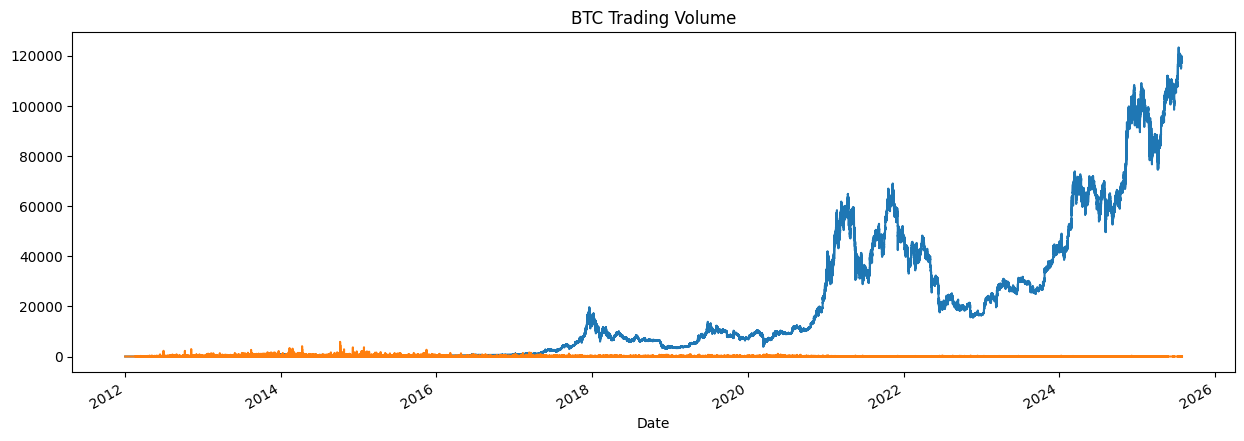

In [6]:
import matplotlib.pyplot as plt

df['Close'].plot(figsize=(15,5), title='BTC Closing Price')
df['Volume'].plot(figsize=(15,5), title='BTC Trading Volume')

In [7]:
df['Return'] = df['Close'].pct_change()
df['Volatility'] = df['Return'].rolling(window=7).std()

In [10]:
df['Log_Return'] = np.log(df['Close']/df['Close'].shift(1))
df['SMA_7'] = df['Close'].rolling(7).mean()
df['Volatility_7'] = df['Log_Return'].rolling(7).std()
df['Hour'] = df.index.hour
df['DayOfWeek'] = df.index.dayofweek

In [11]:
# Expected frequency: 1 minute
full_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq='1T')
missing = full_range.difference(df.index)
print(f"Missing timestamps: {len(missing)}")

/var/folders/yj/2dw3syk175145_7bts9_4vqr0000gn/T/ipykernel_13127/2326119011.py:2: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq='1T')


Missing timestamps: 1160


In [12]:
flat_candles = (df['Open'] == df['Close']) & (df['High'] == df['Low'])
print(f"Flat candles: {flat_candles.sum()}")

Flat candles: 2267020


In [13]:
for lag in [1, 5, 15, 30, 60]:  # lags in minutes
    df[f'Close_lag_{lag}'] = df['Close'].shift(lag)
    df[f'Return_lag_{lag}'] = df['Log_Return'].shift(lag)

In [14]:
!pip install ta
import ta

# Relative Strength Index (RSI)
df['RSI_14'] = ta.momentum.RSIIndicator(df['Close'], window=14).rsi()

# MACD (Trend Indicator)
macd = ta.trend.MACD(df['Close'])
df['MACD'] = macd.macd()
df['MACD_Signal'] = macd.macd_signal()

# Bollinger Bands (Volatility)
boll = ta.volatility.BollingerBands(df['Close'], window=20)
df['BB_High'] = boll.bollinger_hband()
df['BB_Low'] = boll.bollinger_lband()

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29482 sha256=d129073f45b981d69a052a55284b2a4d0caf9213a9a4dea630452f4589b664e4
  Stored in directory: /Users/gin/Library/Caches/pip/wheels/a1/d7/29/7781cc5eb9a3659d032d7d15bdd0f49d07d2b24fec29f44bc4
Successfully built ta


In [15]:
df['High_Low_Spread'] = df['High'] - df['Low']
df['Close_Open_Spread'] = df['Close'] - df['Open']
df['Close_to_High'] = df['Close'] / df['High']
df['Close_to_Low'] = df['Close'] / df['Low']

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(df['Log_Return'].dropna(), lags=50)
plot_pacf(df['Log_Return'].dropna(), lags=50)

In [ ]:
df['Volume_Close_Corr'] = df['Close'].rolling(60).corr(df['Volume'])

In [ ]:
df_15m = df.resample('15T').agg({
    'Open': 'first',
    'High': 'max',
    'Low': 'min',
    'Close': 'last',
    'Volume': 'sum'
})

In [ ]:
import plotly.graph_objects as go

fig = go.Figure(data=[go.Candlestick(
    x=df.index,
    open=df['Open'],
    high=df['High'],
    low=df['Low'],
    close=df['Close']
)])
fig.update_layout(title='BTC Candlestick Chart', xaxis_rangeslider_visible=False)
fig.show()

In [ ]:
import seaborn as sns
plt.figure(figsize=(12,8))
sns.heatmap(df.corr(), cmap='coolwarm', center=0)